In [10]:
from dps_lake_model import lake_model, get_antropogenic_release
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging,
                           Constant, Constraint, Policy, IpyparallelEvaluator, perform_experiments)
ema_logging.log_to_stderr(ema_logging.DEBUG)
import ipyparallel
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)

import math
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D 
from ema_workbench.analysis import parcoords

# Multi-objective robust decision making (MORDM)


This exercise demostrates the application of MORDM on the lake model, which was used in earlier exercises.

MORDM has four main steps:

(i)	    **problem formulation** based on a systems analytical problem definition framework 

(ii)	**searching** for candidate solutions that optimize multiple objectives by using multi-objective evolutionary algorithms 

(iii)	generating an ensemble of scenarios to **explore** the effects of uncertainties 

(iv)	using **scenario discovery** to detect the vulnerabilities of candidate solutions and improving thecandidate solutions



## Step 1: Problem formulation
### Lake Model

Remember the lake problem used in the assignments in previous weeks. The lake problem is a hypothetical case where the inhabitants of a lake town decide on the amount of annual pollution they release into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication.

The lake problem has 4 **outcome indicators**: 
   - **max_P**: maximum pollution over time, to be minimized
   - **utility**: economic benefits obtained from polluting the lake, to be maximized
   - **inertia**: the percentage of significant annual changes in the anthropogenic pollution rate, to be maximized
   - **reliability**: the percentage of years where the pollution level is below the critical threshold, to be maximized
    
See the lake model exercise for the formulation of these outcome variables.

The lake problem is characterized by both stochastic uncertainty and **deep uncertainty**. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |


The lake problem in previous assignments had 100 decision **levers**, meaning that the decision makers independently decide on the amount of anthropogenic pollution at every time step (100). Then a 'policy' was a set of values for these 100 levers, which you composed by sampling from the range [0, 0.1].   

In this exercise, we will use a more advanced way of deciding on the amout of anhtropogenic polution. We will use a **closed loop** version of the lake model, meaning that $a_t$ (anthropogenic pollution) is dependent on $X_t$ (the pollution level at time t). For instance, the rate of anthropogenic pollutions is lowered if the pollution level is approaching a critical threshold. Here, we use "cubic radial basis functions" following [Quinn et al. 2017](http://www.sciencedirect.com/science/article/pii/S1364815216302250) and formulate $a_t$ as follows:

\begin{equation}
    a_{t} =  min\Bigg(max\bigg(\sum\limits_{j=1}^{n} w_{j}\left\vert{\frac{X_{t,i}-c_{j}}{r_{j}}}\right\vert^3, 0.01\bigg), 0.1\Bigg) \\
    s.t. \\
    -2 \leq c_{j} \leq 2 \\
    0 \leq r_{j} \leq 2 \\ 
    0 \leq w_{j} \leq 1 \\
    \sum\limits_{j=1}^{n} w_{j} = 1
\end{equation}


The parameters that define this function also define the pollution strategy over time. Hence, the decision **levers** are the five parameters of this functions, namely $c_1$, $c_2$, $r_1$, $r_2$ and $w_1$. ($w_2$ = 1 - $w_1$).

Note:: i is index for the realization, given m realizations; j is the index for the radial basis function, given 2 radial basis functions. 

**To formulate this problem, do the following:**

**1) Import the lake model function from dps_lake_model.py**

**2) Create an ema_workbench interface for this problem, with corresponding uncertainties, levers and outcomes as specified above**



In [2]:
#define model
model = Model('dpslake', function=lake_model)

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# set levers
model.levers = [RealParameter("c1", -2, 2),
                RealParameter("c2", -2, 2),
                RealParameter("r1", 0, 2),
                RealParameter("r2", 0, 2),
                RealParameter("w1", 0, 1)]

#specify outcomes
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

#model.constantcs = [Constant('alpha', 0.41),
#                         Constant('reps', 150)],

## Step 2: Searching for candidate solutions

In the second step of MORDM, candidate strategies are identified which are pareto optimal conditional on a reference scenario. These candiate strategies are identified through search with multi-objective evolutionary algorithms, that iteratively evaluate a large number of alternatives on multiple objectives until they find the best candidates. For instance, when we optimize the lake model levers, the lake model function will be called for each candidate evaluation, and the corresponding four objective values will be generated. 

Take the model interface developed in the previous step and use the optimization functionality of the workbench to identify the pareto approximate set of solutions. Try the following:
* change the epsilon values between 0.01 and 0.1, what changes, why?
* change the number of function evaluations from 1000 to 10.000 (this requires using multiprocessing unless you are very patient). What is the difference? You can use  convergence as explained in assignment 7 for this

#### Changing epsilon

In [18]:
with MultiprocessingEvaluator(model) as evaluator:
    results001 = evaluator.optimize(nfe=5000, epsilons=[0.01, 0.01, 0.01, 0.01])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 498/5000 nfe
[MainProcess/INFO] generation 10: 993/5000 nfe
[MainProcess/INFO] generation 15: 1490/5000 nfe
[MainProcess/INFO] generation 20: 1986/5000 nfe
[MainProcess/INFO] generation 25: 2478/5000 nfe
[MainProcess/INFO] generation 30: 2977/5000 nfe
[MainProcess/INFO] generation 35: 3473/5000 nfe
[MainProcess/INFO] generation 40: 3968/5000 nfe
[MainProcess/INFO] generation 45: 4461/5000 nfe
[MainProcess/INFO] generation 50: 4954/5000 nfe
[MainProcess/INFO] optimization completed, found 221 solutions
[MainProcess/INFO] terminating pool


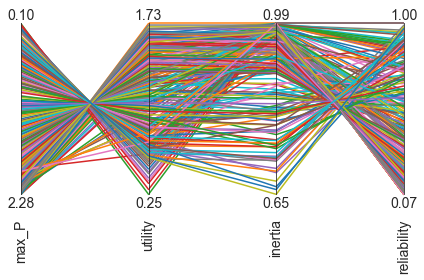

In [19]:
outcomes001 = results001.loc[:, ['max_P', 'utility', 'inertia', 'reliability']]

limits001 = parcoords.get_limits(outcomes001)
axes001 = parcoords.ParallelAxes(limits001)
axes001.plot(outcomes001)

# we invert this axis so direction of desirability is the same 
axes001.invert_axis('max_P') 
plt.show()

In [20]:
with MultiprocessingEvaluator(model) as evaluator:
    results01 = evaluator.optimize(nfe=5000, epsilons=[0.1, 0.1, 0.1, 0.1])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 493/5000 nfe
[MainProcess/INFO] generation 10: 988/5000 nfe
[MainProcess/INFO] generation 15: 1482/5000 nfe
[MainProcess/INFO] generation 20: 1974/5000 nfe
[MainProcess/INFO] generation 25: 2473/5000 nfe
[MainProcess/INFO] generation 30: 2970/5000 nfe
[MainProcess/INFO] generation 35: 3465/5000 nfe
[MainProcess/INFO] generation 40: 3964/5000 nfe
[MainProcess/INFO] generation 45: 4461/5000 nfe
[MainProcess/INFO] generation 50: 4959/5000 nfe
[MainProcess/INFO] optimization completed, found 21 solutions
[MainProcess/INFO] terminating pool


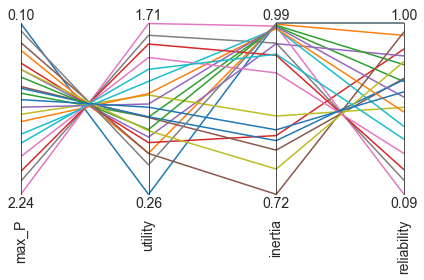

In [21]:
outcomes01 = results01.loc[:, ['max_P', 'utility', 'inertia', 'reliability']]

limits01 = parcoords.get_limits(outcomes01)
axes01 = parcoords.ParallelAxes(limits01)
axes01.plot(outcomes01)

# we invert this axis so direction of desirability is the same 
axes01.invert_axis('max_P') 
plt.show()

#### Changing nfe

In [ ]:
with MultiprocessingEvaluator(model) as evaluator:
    results1000, convergence1000 = evaluator.optimize(nfe=1000, searchover='levers',
                                    epsilons=[0.1, 0.1, 0.1, 0.1])

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence1000.nfe, convergence1000.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence1000.nfe, convergence1000.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [ ]:
with MultiprocessingEvaluator(model) as evaluator:
    results1000, convergence1000 = evaluator.optimize(nfe=10000, searchover='levers',
                                    epsilons=[0.1, 0.1, 0.1, 0.1])

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence10000.nfe, convergence10000.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence10000.nfe, convergence10000.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [22]:
#specify outcomes 
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(model.outcomes),
                       EpsilonProgress()]

constraints = [Constraint("max pollution", outcome_names="max_P",
                          function=lambda x:max(0, x-5))]

In [23]:
with MultiprocessingEvaluator(model) as evaluator:
    results1000, convergence1000 = evaluator.optimize(nfe=1000, searchover='levers',
                                    epsilons=[0.1, 0.1, 0.1, 0.1],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 497/1000 nfe
[MainProcess/INFO] generation 10: 991/1000 nfe
[MainProcess/INFO] optimization completed, found 11 solutions
[MainProcess/INFO] terminating pool


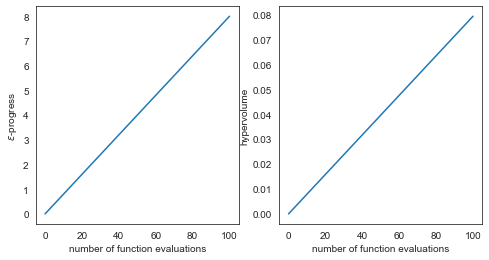

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence1000.nfe, convergence1000.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence1000.nfe, convergence1000.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [25]:
with MultiprocessingEvaluator(model) as evaluator:
    results10000, convergence10000 = evaluator.optimize(nfe=10000, searchover='levers',
                                    epsilons=[0.1, 0.1, 0.1, 0.1],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 496/10000 nfe
[MainProcess/INFO] generation 10: 995/10000 nfe
[MainProcess/INFO] generation 15: 1492/10000 nfe
[MainProcess/INFO] generation 20: 1986/10000 nfe
[MainProcess/INFO] generation 25: 2484/10000 nfe
[MainProcess/INFO] generation 30: 2981/10000 nfe
[MainProcess/INFO] generation 35: 3474/10000 nfe
[MainProcess/INFO] generation 40: 3971/10000 nfe
[MainProcess/INFO] generation 45: 4466/10000 nfe
[MainProcess/INFO] generation 50: 4960/10000 nfe
[MainProcess/INFO] generation 55: 5456/10000 nfe
[MainProcess/INFO] generation 60: 5950/10000 nfe
[MainProcess/INFO] generation 65: 6446/10000 nfe
[MainProcess/INFO] generation 70: 6944/10000 nfe
[MainProcess/INFO] generation 75: 7439/10000 nfe
[MainProcess/INFO] generation 80: 7936/10000 nfe
[MainProcess/INFO] generation 85: 8428/10000 nfe
[MainProcess/INFO] generation 90: 8925/10000 nfe
[MainProcess/INFO] generation 95: 9422/10000

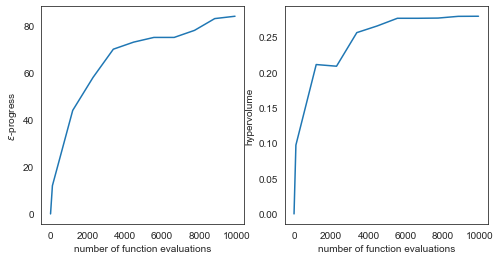

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence10000.nfe, convergence10000.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence10000.nfe, convergence10000.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

Lower epsilon gives more number of solutions. It is seen from the parallel axis plots of epsilon 0.01 has more lines than of epsilon 0.1. 

Higher nfe allows us more to see whether the hypervolume or epsilon-progress has stabilized/converged or not. The nfe=1000's plot shows that the number of function evaluations is not sufficient because we could not see whether hypervolume and 𝜖 -progress has stablized; the plots' lines are increasing. While when we set nfe as 10000, the plots' lines are started to flat at the end.

**plot the tradeoffs you have found using a parallel axis plot**

We can visualize these tradeoffs on **parallel axis plots**. In these plots, each dimension is shown as a vertical axis. Each solution is represented by a line on this plot, which crosses the objective axes at the corresponsing value. You can use the [parcoords functionality](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/parcoords.html) for this that comes with the ema_workbench. Ensure that the direction of desirability is the same for the four objectives.|



**What does this plot tell us about the tradeoffs and conflicting objectives?**

From the last parallel axis plot above, we could see that there is a trade-off between 'max_P' and 'reliability' at one hand, and 'utility' and 'inertia' at the other hand.

## Step 3: Re-evaluate candidate solutions under uncertainty

We now have a large number of candidate solutions (policies), we can re-evaluate them over the various deeply uncertain factors to assess their robustness against uncertainties.

For this robustness evaluation, we need to explore the scenarios for each solution. It means that, if we would like to run for instance 1000 scenarios for each solution, we might have to execute a very large number of runs.

Here, to simplify the case, let's suppose that decision makers have a hard constrain on *reliability*. No solution with less than 90% reliability is acceptable for them. Therefore, we can reduce the size of the solution set according to this constraint. 

**Apply this constraint of reliability on the results, and create a new dataframe named new_reults**


In [3]:
#specify outcomes 
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(model.outcomes),
                       EpsilonProgress()]

In [4]:
#specify constraint

constraints = [Constraint("min reliability", outcome_names="reliability",
                          function=lambda x:max(0, 0.9-x))]

#min(x, 0.9)


**From new_results, which is the reduced dataframe of candidate solutions, make a list of policies in a format that can be inputed to the *perform_experiments* function of the EMA workbench.**

*hint: you need to transform each policy to a dict, and then use this dict as input for the Policy class that comes with the workbench*

In [5]:
with MultiprocessingEvaluator(model) as evaluator:
    newresults, newconvergence = evaluator.optimize(nfe=1000, searchover='levers',
                                    epsilons=[0.01, 0.01, 0.01, 0.01],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 5: 495/1000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 10: 991/1000 nfe
[MainProcess/DEBUG] none received
[MainProcess/INFO] optimization completed, found 14 solutions
[MainProcess/INFO] terminating pool


In [6]:
newresults

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.431058,0.340937,1.854379,0.574463,0.179881,0.167772,0.475549,0.99,1.0
1,0.441679,0.351629,1.953171,0.647556,0.179881,0.159226,0.456359,0.99,1.0
2,0.346399,0.518134,1.824986,1.311485,0.339649,0.129174,0.362599,0.99,1.0
3,0.530492,0.447907,1.820715,0.928362,0.861859,0.119487,0.329379,0.99,1.0
4,0.472440,0.344995,1.859620,0.512131,0.120860,0.189963,0.514641,0.99,1.0
5,0.441679,0.351629,1.901359,0.497374,0.153922,0.197905,0.525900,0.99,1.0
6,0.380280,0.219966,1.146569,0.543863,0.210359,0.099166,0.263318,0.99,1.0
7,-0.126483,0.347498,1.829326,0.456945,0.208339,0.204325,0.533895,0.99,1.0
8,0.432245,0.341661,1.821747,0.518080,0.267683,0.177885,0.494890,0.99,1.0
9,0.346399,0.387485,1.193549,0.534154,0.188135,0.218308,0.545965,0.99,1.0


In [7]:
pols = newresults.loc[:,['c1','c2','r1','r2','w1']]

In [8]:
policies = []
for i in range(len(pols)):
    c1 = pols.iloc[i,0]
    c2 = pols.iloc[i,1]
    r1 = pols.iloc[i,2]
    r2 = pols.iloc[i,3]
    w1 = pols.iloc[i,4]
    policies.append(Policy(f"{i}",**{"c1": c1, "c2": c2, "r1": r1, "r2": r2, "w1": w1}))
policies

[Policy({'c1': 0.43105756914078874, 'c2': 0.3409369399586244, 'r1': 1.8543793257434458, 'r2': 0.5744625865523556, 'w1': 0.1798814331609666}),
 Policy({'c1': 0.4416785541388742, 'c2': 0.3516290166202918, 'r1': 1.9531714890720573, 'r2': 0.6475559983851763, 'w1': 0.1798814331609666}),
 Policy({'c1': 0.3463986360729474, 'c2': 0.5181343994675389, 'r1': 1.8249860010550232, 'r2': 1.3114846911193894, 'w1': 0.33964947979098525}),
 Policy({'c1': 0.5304915432238702, 'c2': 0.44790675095229004, 'r1': 1.8207152358335443, 'r2': 0.9283619915166049, 'w1': 0.8618585601149527}),
 Policy({'c1': 0.4724398584433031, 'c2': 0.34499527252098106, 'r1': 1.8596196305226167, 'r2': 0.5121314897019378, 'w1': 0.12086024120976253}),
 Policy({'c1': 0.4416785541388742, 'c2': 0.3516290166202918, 'r1': 1.9013587536075218, 'r2': 0.49737387083801227, 'w1': 0.15392197048695588}),
 Policy({'c1': 0.3802803059924137, 'c2': 0.21996614416739757, 'r1': 1.1465691365949275, 'r2': 0.5438629489334943, 'w1': 0.21035945758543853}),
 Pol

**Perform 1000 scenarios for each of the policy options. Depending on how many solutions are left after implementing the constraint, consider using multiprocessing or ipyparallel to speed up calculations.**

If you want to use ipyparallel, don't forget to start ipcluster.

In [11]:
#with MultiprocessingEvaluator(model) as evaluator:
#    polresults = evaluator.perform_experiments(scenarios=1000, policies=policies, uncertainty_sampling='lhs')
with MultiprocessingEvaluator(model) as evaluator:
    polresults = perform_experiments(model, 1000, policies, evaluator=evaluator)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 14 policies * 1 model(s) = 14000 experiments
[MainProcess/DEBUG] 1 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing iner

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 45 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 46 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 47 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 48 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 49 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 50 cases comple

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 90 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 91 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 92 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 93 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 94 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[Main

[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 134 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 135 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 136 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 137 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 138 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inerti

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 178 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 179 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 180 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 181 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 182 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliab

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 222 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 223 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 224 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 225 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 226 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 227 cases 

[MainProcess/DEBUG] 266 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 267 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 268 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 269 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 270 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 271 cases completed
[MainProcess/DEBUG] storing ma

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 311 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 312 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 313 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 314 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 315 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility


[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 355 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 356 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 357 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 358 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 359 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inerti

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 399 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 400 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 401 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 402 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 403 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliab

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 443 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 444 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 445 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 446 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 447 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 448 cases 

[MainProcess/DEBUG] 487 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 488 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 489 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 490 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 491 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 492 cases completed
[MainProcess/DEBUG] storing ma

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 532 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 533 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 534 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 535 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 536 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility


[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 576 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 577 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 578 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 579 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 580 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inerti

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 620 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 621 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 622 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 623 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 624 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliab

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 664 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 665 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 666 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 667 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 668 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 669 cases 

[MainProcess/DEBUG] 708 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 709 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 710 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 711 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 712 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 713 cases completed
[MainProcess/DEBUG] storing ma

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 753 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 754 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 755 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 756 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 757 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility


[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 797 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 798 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 799 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 800 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 801 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inerti

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 841 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 842 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 843 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 844 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 845 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliab

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 885 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 886 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 887 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 888 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 889 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 890 cases 

[MainProcess/DEBUG] 929 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 930 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 931 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 932 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 933 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 934 cases completed
[MainProcess/DEBUG] storing ma

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 974 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 975 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 976 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 977 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 978 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility


[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1018 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1019 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1020 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1021 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1022 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1062 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1063 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1064 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1065 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1066 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1106 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1107 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1108 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1109 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1110 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1150 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1151 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1152 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1153 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1154 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1194 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1195 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1196 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1197 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1198 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1238 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1239 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1240 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1241 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1242 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1282 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1283 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1284 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1285 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1286 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1326 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1327 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1328 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1329 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1330 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1370 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1371 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1372 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1373 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1374 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] 1413 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1414 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1415 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1416 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1417 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1418 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 1457 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1458 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1459 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1460 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1461 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1462 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 1501 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1502 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1503 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1504 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1505 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1506 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 1545 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1546 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1547 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1548 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1549 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1550 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 1589 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1590 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1591 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1592 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1593 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1594 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 1633 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1634 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1635 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1636 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1637 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1638 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 1677 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1678 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1679 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1680 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1681 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1682 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 1721 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1722 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1723 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1724 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1725 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1726 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 1765 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1766 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1767 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1768 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1769 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1770 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 1809 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1810 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1811 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1812 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1813 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1814 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 1853 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1854 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1855 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1856 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1857 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1858 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 1897 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1898 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1899 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1900 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1901 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1902 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 1941 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1942 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1943 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1944 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1945 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1946 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 1985 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1986 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1987 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1988 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1989 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 1990 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2029 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2030 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2031 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2032 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2033 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2034 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2073 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2074 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2075 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2076 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2077 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2078 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2117 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2118 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2119 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2120 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2121 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2122 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2161 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2162 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2163 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2164 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2165 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2166 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2205 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2206 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2207 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2208 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2209 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2210 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2249 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2250 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2251 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2252 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2253 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2254 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2293 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2294 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2295 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2296 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2297 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2298 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2337 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2338 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2339 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2340 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2341 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2342 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2381 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2382 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2383 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2384 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2385 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2386 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2425 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2426 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2427 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2428 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2429 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2430 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2469 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2470 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2471 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2472 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2473 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2474 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2513 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2514 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2515 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2516 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2517 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2518 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2557 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2558 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2559 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2560 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2561 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2562 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2601 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2602 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2603 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2604 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2605 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2606 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2645 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2646 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2647 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2648 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2649 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2650 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2689 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2690 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2691 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2692 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2693 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2694 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2733 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2734 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2735 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2736 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2737 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2738 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 2777 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2778 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2779 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2780 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2781 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2782 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2821 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2822 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2823 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2824 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2825 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2826 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2865 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2866 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2867 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2868 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2869 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2870 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2909 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2910 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2911 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2912 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2913 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2914 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2953 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2954 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2955 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2956 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2957 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2958 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2997 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2998 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 2999 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3000 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3001 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3002 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3041 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3042 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3043 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3044 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3045 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3046 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3085 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3086 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3087 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3088 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3089 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3090 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3129 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3130 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3131 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3132 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3133 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3134 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3173 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3174 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3175 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3176 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3177 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3178 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3217 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3218 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3219 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3220 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3221 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3222 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3261 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3262 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3263 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3264 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3265 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3266 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3305 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3306 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3307 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3308 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3309 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3310 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3349 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3350 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3351 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3352 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3353 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3354 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3393 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3394 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3395 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3396 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3397 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3398 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3437 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3438 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3439 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3440 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3441 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3442 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3481 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3482 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3483 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3484 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3485 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3486 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3525 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3526 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3527 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3528 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3529 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3530 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3569 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3570 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3571 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3572 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3573 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3574 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3613 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3614 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3615 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3616 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3617 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3618 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3657 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3658 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3659 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3660 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3661 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3662 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3701 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3702 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3703 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3704 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3705 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3706 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3745 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3746 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3747 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3748 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3749 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3750 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3789 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3790 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3791 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3792 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3793 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3794 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3833 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3834 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3835 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3836 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3837 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3838 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3877 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3878 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3879 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3880 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3881 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3882 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3921 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3922 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3923 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3924 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3925 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3926 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3965 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3966 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3967 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3968 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3969 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 3970 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4009 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4010 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4011 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4012 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4013 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4014 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4053 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4054 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4055 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4056 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4057 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4058 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4097 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4098 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4099 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4100 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4101 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4102 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4141 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4142 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4143 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4144 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4145 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4146 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4185 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4186 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4187 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4188 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4189 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4190 

[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4229 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4230 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4231 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4232 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4233 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing i

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4273 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4274 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4275 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4276 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4277 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4317 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4318 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4319 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4320 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4321 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4361 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4362 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4363 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4364 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4365 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4405 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4406 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4407 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4408 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4409 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4449 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4450 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4451 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4452 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4453 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4493 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4494 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4495 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4496 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4497 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4537 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4538 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4539 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4540 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4541 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4581 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4582 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4583 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4584 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4585 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4625 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4626 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4627 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4628 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4629 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4669 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4670 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4671 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4672 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4673 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4713 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4714 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4715 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4716 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4717 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4757 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4758 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4759 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4760 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4761 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4801 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4802 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4803 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4804 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4805 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4845 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4846 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4847 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4848 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4849 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4889 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4890 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4891 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4892 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4893 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4933 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4934 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4935 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4936 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4937 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4977 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4978 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4979 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4980 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 4981 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5021 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5022 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5023 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5024 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5025 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5065 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5066 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5067 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5068 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5069 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5109 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5110 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5111 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5112 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5113 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5153 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5154 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5155 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5156 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5157 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5197 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5198 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5199 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5200 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5201 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5241 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5242 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5243 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5244 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5245 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5285 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5286 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5287 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5288 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5289 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5329 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5330 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5331 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5332 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5333 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5373 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5374 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5375 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5376 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5377 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5417 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5418 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5419 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5420 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5421 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5461 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5462 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5463 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5464 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5465 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5505 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5506 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5507 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5508 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5509 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5549 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5550 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5551 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5552 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5553 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5593 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5594 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5595 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5596 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5597 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] 5636 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5637 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5638 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5639 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5640 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5641 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 5680 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5681 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5682 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5683 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5684 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5685 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 5724 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5725 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5726 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5727 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5728 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5729 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 5768 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5769 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5770 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5771 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5772 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5773 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 5812 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5813 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5814 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5815 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5816 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5817 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 5856 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5857 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5858 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5859 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5860 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5861 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 5900 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5901 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5902 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5903 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5904 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5905 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 5944 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5945 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5946 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5947 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5948 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5949 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 5988 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5989 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5990 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5991 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5992 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 5993 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6032 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6033 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6034 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6035 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6036 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6037 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6076 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6077 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6078 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6079 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6080 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6081 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6120 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6121 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6122 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6123 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6124 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6125 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6164 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6165 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6166 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6167 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6168 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6169 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6208 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6209 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6210 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6211 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6212 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6213 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6252 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6253 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6254 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6255 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6256 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6257 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6296 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6297 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6298 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6299 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6300 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6301 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6340 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6341 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6342 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6343 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6344 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6345 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6384 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6385 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6386 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6387 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6388 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6389 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6428 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6429 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6430 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6431 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6432 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6433 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6472 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6473 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6474 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6475 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6476 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6477 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6516 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6517 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6518 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6519 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6520 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6521 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6560 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6561 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6562 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6563 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6564 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6565 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6604 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6605 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6606 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6607 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6608 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6609 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6648 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6649 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6650 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6651 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6652 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6653 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6692 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6693 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6694 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6695 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6696 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6697 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6736 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6737 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6738 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6739 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6740 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6741 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6780 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6781 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6782 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6783 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6784 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6785 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6824 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6825 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6826 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6827 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6828 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6829 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6868 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6869 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6870 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6871 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6872 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6873 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6912 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6913 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6914 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6915 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6916 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6917 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 6956 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6957 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6958 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6959 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6960 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 6961 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 7000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7001 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7002 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7003 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7004 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7005 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7044 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7045 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7046 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7047 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7048 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7049 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7088 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7089 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7090 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7091 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7092 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7093 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7132 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7133 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7134 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7135 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7136 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7137 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7176 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7177 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7178 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7179 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7180 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7181 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7220 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7221 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7222 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7223 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7224 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7225 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7264 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7265 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7266 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7267 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7268 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7269 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7308 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7309 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7310 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7311 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7312 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7313 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7352 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7353 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7354 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7355 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7356 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7357 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7396 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7397 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7398 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7399 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7400 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7401 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7440 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7441 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7442 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7443 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7444 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7445 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7484 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7485 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7486 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7487 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7488 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7489 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7528 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7529 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7530 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7531 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7532 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7533 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7572 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7573 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7574 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7575 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7576 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7577 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7616 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7617 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7618 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7619 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7620 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7621 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7660 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7661 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7662 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7663 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7664 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7665 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7704 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7705 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7706 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7707 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7708 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7709 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7748 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7749 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7750 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7751 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7752 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7753 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7792 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7793 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7794 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7795 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7796 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7797 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7836 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7837 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7838 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7839 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7840 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7841 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7880 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7881 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7882 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7883 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7884 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7885 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7924 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7925 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7926 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7927 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7928 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7929 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7968 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7969 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7970 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7971 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7972 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 7973 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8012 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8013 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8014 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8015 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8016 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8017 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8056 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8057 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8058 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8059 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8060 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8061 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8100 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8101 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8102 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8103 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8104 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8105 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8144 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8145 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8146 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8147 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8148 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8149 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8188 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8189 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8190 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8191 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8192 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8193 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8232 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8233 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8234 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8235 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8236 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8237 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8276 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8277 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8278 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8279 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8280 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8281 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8320 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8321 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8322 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8323 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8324 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8325 

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8364 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8365 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8366 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8367 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8368 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8369 

[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8408 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8409 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8410 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8411 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8412 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing i

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8452 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8453 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8454 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8455 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8456 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8496 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8497 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8498 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8499 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8500 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8540 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8541 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8542 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8543 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8544 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8584 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8585 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8586 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8587 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8588 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8628 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8629 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8630 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8631 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8632 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8672 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8673 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8674 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8675 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8676 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8716 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8717 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8718 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8719 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8720 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8760 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8761 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8762 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8763 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8764 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8804 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8805 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8806 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8807 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8808 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8848 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8849 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8850 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8851 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8852 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8892 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8893 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8894 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8895 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8896 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8936 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8937 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8938 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8939 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8940 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8980 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8981 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8982 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8983 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 8984 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9024 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9025 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9026 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9027 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9028 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9068 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9069 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9070 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9071 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9072 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9112 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9113 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9114 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9115 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9116 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9156 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9157 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9158 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9159 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9160 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9200 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9201 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9202 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9203 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9204 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9244 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9245 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9246 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9247 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9248 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9288 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9289 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9290 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9291 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9292 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9332 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9333 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9334 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9335 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9336 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9376 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9377 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9378 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9379 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9380 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9420 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9421 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9422 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9423 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9424 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9464 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9465 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9466 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9467 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9468 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9508 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9509 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9510 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9511 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9512 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9552 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9553 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9554 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9555 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9556 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9596 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9597 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9598 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9599 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9600 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9640 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9641 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9642 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9643 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9644 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9684 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9685 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9686 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9687 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9688 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9728 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9729 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9730 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9731 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9732 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9772 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9773 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9774 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9775 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9776 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing uti

[MainProcess/DEBUG] 9815 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9816 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9817 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9818 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9819 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9820 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 9859 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9860 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9861 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9862 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9863 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9864 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 9903 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9904 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9905 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9906 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9907 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9908 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 9947 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9948 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9949 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9950 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9951 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9952 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 9991 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9992 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9993 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9994 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9995 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 9996 cases completed
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10035 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10036 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10037 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10038 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10039 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 

[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10079 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10080 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10081 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10082 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10083 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 10122 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10123 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10124 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10125 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10126 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10127 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10166 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10167 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10168 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10169 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10170 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10210 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10211 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10212 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10213 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10214 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 10253 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10254 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10255 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10256 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10257 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10258 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10297 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10298 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10299 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10300 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10301 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10341 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10342 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10343 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10344 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10345 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 10384 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10385 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10386 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10387 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10388 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10389 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10428 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10429 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10430 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10431 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10432 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10472 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10473 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10474 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10475 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10476 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 10515 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10516 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10517 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10518 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10519 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10520 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10559 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10560 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10561 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10562 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10563 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10603 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10604 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10605 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10606 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10607 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 10646 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10647 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10648 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10649 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10650 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10651 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10690 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10691 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10692 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10693 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10694 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10734 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10735 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10736 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10737 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10738 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 10777 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10778 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10779 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10780 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10781 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10782 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10821 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10822 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10823 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10824 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10825 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10865 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10866 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10867 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10868 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10869 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 10908 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10909 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10910 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10911 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10912 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10913 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10952 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10953 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10954 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10955 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10956 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10996 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10997 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10998 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 10999 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11000 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 11039 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11040 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11041 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11042 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11043 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11044 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11083 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11084 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11085 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11086 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11087 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11127 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11128 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11129 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11130 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11131 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 11170 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11171 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11172 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11173 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11174 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11175 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11214 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11215 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11216 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11217 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11218 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 11257 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11258 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11259 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11260 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11261 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11262 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11301 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11302 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11303 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11304 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11305 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11345 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11346 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11347 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11348 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11349 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 11388 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11389 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11390 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11391 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11392 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11393 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11432 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11433 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11434 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11435 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11436 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11476 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11477 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11478 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11479 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11480 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 11519 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11520 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11521 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11522 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11523 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11524 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11563 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11564 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11565 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11566 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11567 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11607 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11608 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11609 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11610 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11611 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 11650 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11651 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11652 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11653 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11654 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11655 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11694 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11695 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11696 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11697 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11698 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11738 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11739 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11740 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11741 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11742 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 11781 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11782 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11783 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11784 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11785 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11786 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11825 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11826 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11827 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11828 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11829 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11869 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11870 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11871 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11872 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11873 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 11912 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11913 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11914 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11915 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11916 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11917 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11956 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11957 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11958 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11959 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 11960 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12000 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12001 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12002 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12003 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12004 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 12043 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12044 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12045 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12046 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12047 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12048 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12087 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12088 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12089 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12090 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12091 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12131 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12132 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12133 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12134 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12135 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 12174 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12175 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12176 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12177 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12178 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12179 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12218 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12219 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12220 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12221 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12222 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12262 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12263 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12264 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12265 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12266 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 12305 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12306 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12307 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12308 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12309 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12310 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12349 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12350 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12351 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12352 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12353 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12393 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12394 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12395 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12396 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12397 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 12436 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12437 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12438 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12439 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12440 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12441 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12480 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12481 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12482 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12483 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12484 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12524 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12525 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12526 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12527 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12528 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 12567 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12568 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12569 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12570 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12571 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12572 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12611 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12612 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12613 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12614 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12615 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] 12654 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12655 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12656 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12657 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12658 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12659 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12698 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12699 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12700 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12701 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12702 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12742 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12743 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12744 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12745 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12746 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 12785 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12786 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12787 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12788 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12789 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12790 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12829 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12830 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12831 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12832 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12833 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12873 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12874 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12875 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12876 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12877 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 12916 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12917 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12918 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12919 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12920 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12921 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12960 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12961 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12962 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12963 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 12964 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13004 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13005 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13006 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13007 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13008 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 13047 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13048 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13049 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13050 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13051 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13052 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13091 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13092 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13093 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13094 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13095 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13135 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13136 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13137 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13138 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13139 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 13178 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13179 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13180 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13181 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13182 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13183 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13222 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13223 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13224 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13225 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13226 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13266 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13267 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13268 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13269 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13270 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 13309 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13310 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13311 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13312 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13313 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13314 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13353 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13354 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13355 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13356 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13357 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13397 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13398 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13399 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13400 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13401 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 13440 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13441 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13442 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13443 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13444 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13445 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13484 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13485 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13486 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13487 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13488 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13528 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13529 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13530 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13531 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13532 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 13571 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13572 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13573 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13574 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13575 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13576 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13615 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13616 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13617 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13618 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13619 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13659 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13660 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13661 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13662 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13663 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 13702 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13703 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13704 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13705 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13706 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13707 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13746 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13747 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13748 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13749 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13750 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13790 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13791 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13792 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13793 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13794 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 13833 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13834 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13835 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13836 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13837 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13838 cases completed
[MainProcess/DEBUG

[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13877 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13878 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13879 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13880 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13881 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] stor

[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13921 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13922 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13923 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13924 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13925 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storin

[MainProcess/DEBUG] 13964 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13965 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13966 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13967 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13968 cases completed
[MainProcess/DEBUG] storing max_P
[MainProcess/DEBUG] storing utility
[MainProcess/DEBUG] storing inertia
[MainProcess/DEBUG] storing reliability
[MainProcess/DEBUG] 13969 cases completed
[MainProcess/DEBUG

In [12]:
polresults

(              b     delta      mean         q     stdev        c1        c2  \
 0      0.143873  0.940470  0.046016  2.527338  0.002564  0.431058  0.340937   
 1      0.206861  0.989070  0.037152  2.727363  0.004746  0.431058  0.340937   
 2      0.301042  0.951906  0.014977  2.042490  0.003303  0.431058  0.340937   
 3      0.107548  0.947965  0.048562  3.620080  0.003061  0.431058  0.340937   
 4      0.164851  0.982112  0.011036  2.127996  0.003553  0.431058  0.340937   
 ...         ...       ...       ...       ...       ...       ...       ...   
 13995  0.448286  0.969410  0.011949  3.293749  0.003016  0.346399  0.387621   
 13996  0.362224  0.948469  0.037720  3.150292  0.004896  0.346399  0.387621   
 13997  0.166215  0.961687  0.025223  2.123255  0.001351  0.346399  0.387621   
 13998  0.339729  0.941492  0.029869  3.760239  0.002038  0.346399  0.387621   
 13999  0.245486  0.933392  0.049143  4.208779  0.001281  0.346399  0.387621   
 
              r1        r2        w1 s

We can now evaluate the **robustness** of each of the policy options based on these scenario results. We can calculate the robustness of a policy option in terms of its performance on an outcome indicator across the 1000 scenarios. In other words, we can identify how robust a policy is in terms of each outcome indicator, and investigate the robustness tradeoffs.  

There are multiple metrics to quantify robustness. On of them is the *signal to noise ratio*, which is simply the mean of a dataset divided by its standard deviation. For instance, for an outcome indicator to be maximized, we prefer a high average value across the scenarios, and a low standard deviation, implying a narrow uncertaintiy range. Therefore, we want to maximize the signal-to-noise ratio. For an outcome indicator to be minimized, a lower mean and a lower standard deviation is preferred. Therefore the formulation is different.

**Write a function to calculate the signal-to-noise ratio for both kinds of outcome indicators. Calculate the signal-to-noise ratios for each outcome and each policy option. Plot the tradeoffs on a parallel axis plot. Which solutions look like a good compromise policy?**

In [ ]:
#signal to noise ratio, which is simply the mean of a dataset divided by its standard deviation

Another robustness metric is **maximum regret**, calculated again for each policy and for each outcome indicator. *Regret* is defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the berformance of a no-regret (i.e. best possible result in that scenario) policy. The *maximum regret*  is then the maximum of such regret values across all scenarios. We of course favor policy options with low *maximum regret* values. 

**Write a function to calculate the maximum regret. Calculate the maximum regret values for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

We now have an understanding of which solutions have decent robustness using 2 different robustness metrics. A related but different question is to assess the uncertain conditions under which we get poor performance. For this, we can use scenario discovery. Since we want to identify the uncertainties only, we can remove the policy column from the experiments DataFrame. 

**Perform Scenario Discovery, focussed on understanding the conditions under which utility is lower than 0.25**

from the trade off curve between coverage, density and number of restricted dimensions, select a point which balances them. Next, using the `yi` attribute, select from the experiments data frame the rows which are within the box as well as the outcomes associated with these experiments.Save these results. They are the starting point for the next assignment. In pseudo code:

```python
from ema_workbench import save_results

selected_experiments = experiments.iloc[box.yi]
selected_outcomes = {k:v[box.yi] for k,v in outcomes.items()}

save_results((selected_experiments, selected_outcomes), './results/selected_results.tar.gz')
```





In [59]:
with MultiprocessingEvaluator(model) as evaluator:
    new_results, new_convergence = evaluator.optimize(nfe=1000, searchover='uncertainties',
                                    epsilons=[0.01, 0.01, 0.01, 0.01],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 495/1000 nfe
[MainProcess/INFO] generation 10: 988/1000 nfe
[MainProcess/INFO] optimization completed, found 2 solutions


In [61]:
new_results

,b,q,mean,stdev,delta,max_P,utility,inertia,reliability
0,0.449526,4.050820,0.010378,0.004674,0.989803,0.110940,0.835357,0.99,1.0
1,0.441724,3.596622,0.010174,0.004651,0.989478,0.109671,0.816742,0.99,1.0


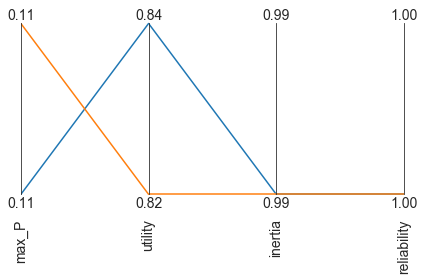

In [60]:
newoutcomes = new_results.loc[:, ['max_P', 'utility', 'inertia', 'reliability']]

newlimits = parcoords.get_limits(newoutcomes)
newaxes = parcoords.ParallelAxes(newlimits)
newaxes.plot(newoutcomes)

# we invert this axis so direction of desirability is the same 
newaxes.invert_axis('max_P') 
plt.show()

In [87]:
client = ipyparallel.Client()
client.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [88]:
%%px --local

import math
import numpy as np

from scipy.optimize import brentq


def get_antropogenic_release(xt, c1, c2, r1, r2, w1):
    rule = w1*(abs(xt-c1)/r1)**3+(1-w1)*(abs(xt-c2)/r2)**3
    at1 = max(rule, 0.01)
    at = min(at1, 0.1)

    return at


def lake_model(b=0.42, q=2.0, mean=0.02,
               stdev=0.001, delta=0.98, alpha=0.4,
               nsamples=100, myears=100, c1=0.25,
               c2=0.25, r1=0.5, r2=0.5,
               w1=0.5, seed=None):
    
    np.random.seed(seed)
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)

    X = np.zeros((myears,))
    average_daily_P = np.zeros((myears,))
    reliability = 0.0
    inertia = 0
    utility = 0

    for _ in range(nsamples):
        X[0] = 0.0
        decision = 0.1

        decisions = np.zeros(myears,)
        decisions[0] = decision

        natural_inflows = np.random.lognormal(
            math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
            math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
            size=myears)

        for t in range(1, myears):

            # here we use the decision rule
            decision = get_antropogenic_release(X[t-1], c1, c2, r1, r2, w1)
            decisions[t] = decision

            X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decision +\
                natural_inflows[t-1]
            average_daily_P[t] += X[t]/nsamples

        reliability += np.sum(X < Pcrit)/(nsamples*myears)
        inertia += np.sum(np.absolute(np.diff(decisions)
                                      < 0.02)) / (nsamples*myears)
        utility += np.sum(alpha*decisions*np.power(delta,
                                                   np.arange(myears))) / nsamples
    max_P = np.max(average_daily_P)
    return max_P, utility, inertia, reliability

In [89]:
#define model
modelipp = Model('dpslake', function=lake_model)

#specify uncertainties
modelipp.uncertainties = [RealParameter('b', 0.1, 0.45),
                          RealParameter('q', 2.0, 4.5),
                          RealParameter('mean', 0.01, 0.05),
                          RealParameter('stdev', 0.001, 0.005),
                          RealParameter('delta', 0.93, 0.99)]

# set levers
modelipp.levers = [RealParameter("c1", -2, 2),
                   RealParameter("c2", -2, 2),
                   RealParameter("r1", 0, 2),
                   RealParameter("r2", 0, 2),
                   RealParameter("w1", 0, 1)]

#specify outcomes
modelipp.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                     ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                     ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                     ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

#model.constantcs = [Constant('alpha', 0.41),
#                         Constant('reps', 150)],

In [ ]:
with IpyparallelEvaluator(modelipp, client=client) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000, policies=policies)

In [ ]:
results